In [1]:
# Note: Original saved in Tahir Sproj folder

# Deep Learning Libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data

# Data Manipulation and Analysis
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib
import matplotlib.pyplot as plt

# File and System Interaction
import os
from pathlib import Path
import shutil
import torch.optim as optim


# Date and Time Handling
import time
import datetime

# Linear Algebra
from torch import linalg as LA

# Neural Architecture
try:
    from torchinfo import summary
except:
    # %pip install torchinfo
    from torchinfo import summary

In [2]:
%load_ext autoreload
%autoreload 2

from python_scripts import dataset_processing
from python_scripts import architecture
from python_scripts import revised_architecture
from python_scripts import training
from python_scripts import logs_and_results

In [3]:
# Setting up some global variables

# ROOT = 'C:/Users/Talha/OneDrive - Higher Education Commission/Documents/GitHub/ConvHuberMC/HuberMC_Data'
ROOT = 'C:/Users/HP/GitHub Workspace/ConvHuberMC-Net/HuberMC_Data'
TRY = 'Try 1'
SESSION = 'Session 1'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [24]:
import glob
import re

def get_all_text_files(folder_path):
    # Create a pattern to match all .txt files in the folder and subfolders
    pattern = f"{folder_path}/**/*.txt"
    # Use glob to find all files matching the pattern, with recursive search
    return glob.glob(pattern, recursive=True)

# Usage example
folder_path = 'C:/Users/Talha/OneDrive - Higher Education Commission/Documents/GitHub/ConvHuberMC/HuberMC_Data'
text_files = get_all_text_files(folder_path)
print(text_files, len(text_files))


['C:/Users/Talha/OneDrive - Higher Education Commission/Documents/GitHub/ConvHuberMC/HuberMC_Data\\Q 20.0%\\DB 3.0\\Logs\\HuberMC-Net\\Session 1\\Try 1 HuberMC-Net Q 20.0% DB 3.0 Layers_3_TrainInstances_20_Epochs_20_lr_0.001.txt', 'C:/Users/Talha/OneDrive - Higher Education Commission/Documents/GitHub/ConvHuberMC/HuberMC_Data\\Q 20.0%\\DB 5.0\\Logs\\HuberMC-Net\\Session 1\\Try 1 HuberMC-Net Q 20.0% DB 5.0 Layers_3_TrainInstances_20_Epochs_20_lr_0.001.txt', 'C:/Users/Talha/OneDrive - Higher Education Commission/Documents/GitHub/ConvHuberMC/HuberMC_Data\\Q 20.0%\\DB 6.0\\Logs\\HuberMC-Net\\Session 1\\Try 1 HuberMC-Net Q 20.0% DB 6.0 Layers_3_TrainInstances_20_Epochs_20_lr_0.001.txt', 'C:/Users/Talha/OneDrive - Higher Education Commission/Documents/GitHub/ConvHuberMC/HuberMC_Data\\Q 20.0%\\DB 9.0\\Logs\\HuberMC-Net\\Session 1\\Try 1 HuberMC-Net Q 20.0% DB 9.0 Layers_3_TrainInstances_20_Epochs_20_lr_0.001.txt', 'C:/Users/Talha/OneDrive - Higher Education Commission/Documents/GitHub/ConvHub

In [25]:
def normalize_paths(file_paths):
    # Iterate over the file paths and replace '//' with '/'
    # return [re.sub(r'\+', '/', path) for path in file_paths]
    return [path.replace('\\', '/') for path in file_paths]
                         
text_files = normalize_paths(text_files)

In [35]:
import numpy as np
import re

def extract_min_losses(file_paths):
    losses = []
    for path in file_paths:
        with open(path, 'r') as file:
            text = file.read()
            # match = re.search(r'Min Loss = ([\d\.]+e[+\-]\d+)', text)
            match = re.search(r'Epoch \[20/20\], Mean Training Loss:.*?, Mean Validation Loss:(\d+\.\d+e[+\-]\d+)', text)
            if match:
                loss = float(match.group(1))
                losses.append(loss)
            else:
                # Append NaN if no loss is found
                losses.append(np.nan)

    # Ensure we have exactly 28 losses to reshape into a 4x7 array
    if len(losses) == 28:
        return np.array(losses).reshape(4, 7)
    else:
        raise ValueError(f'Expected 28 loss values, but got {len(losses)}.')

# Example usage, replace 'fixed_paths' with your actual list of file paths
# fixed_paths = ['path/to/your/file1.txt', 'path/to/your/file2.txt', ...]
losses_array = extract_min_losses(text_files)
print(losses_array)

[[12.3448    12.5409    11.1607    11.1087     4.76935          nan
   4.68705  ]
 [ 4.36288    4.09715    1.6018     1.64739    1.41187    0.770029
   0.700977 ]
 [ 0.657825   0.641308   0.544685   0.297997   0.299707   0.2999
   0.249103 ]
 [ 0.1213     0.155548   0.120986   0.127929   0.0660166  0.120745
   0.0633612]]


In [36]:
unfolded_results = losses_array.reshape(7, 4).T

In [31]:
unfolded_results[:, 0]

array([12.328, 12.541, 11.161, 11.109])

In [37]:
unfolded_results

array([[12.3448   ,  4.76935  ,  4.09715  ,  0.770029 ,  0.544685 ,
         0.249103 ,  0.127929 ],
       [12.5409   ,        nan,  1.6018   ,  0.700977 ,  0.297997 ,
         0.1213   ,  0.0660166],
       [11.1607   ,  4.68705  ,  1.64739  ,  0.657825 ,  0.299707 ,
         0.155548 ,  0.120745 ],
       [11.1087   ,  4.36288  ,  1.41187  ,  0.641308 ,  0.2999   ,
         0.120986 ,  0.0633612]])

In [32]:
data = """
24.5695    0.0529    0.0307    0.0197    0.0148    0.0135    0.0107
11.6203    0.0391    0.0209    0.0114    0.0100    0.0077    0.0068
14.0508    0.0271    0.0148    0.0095    0.0084    0.0061    0.0057
6.2097    0.0152    0.0083    0.0049    0.0041    0.0032    0.0025
"""

# Convert the string to a list of numbers, then reshape into a 4x7 array
array = np.fromstring(data, sep=' ').reshape(4, 7)
print(array)

[[2.45695e+01 5.29000e-02 3.07000e-02 1.97000e-02 1.48000e-02 1.35000e-02
  1.07000e-02]
 [1.16203e+01 3.91000e-02 2.09000e-02 1.14000e-02 1.00000e-02 7.70000e-03
  6.80000e-03]
 [1.40508e+01 2.71000e-02 1.48000e-02 9.50000e-03 8.40000e-03 6.10000e-03
  5.70000e-03]
 [6.20970e+00 1.52000e-02 8.30000e-03 4.90000e-03 4.10000e-03 3.20000e-03
  2.50000e-03]]


#### Model path of loading

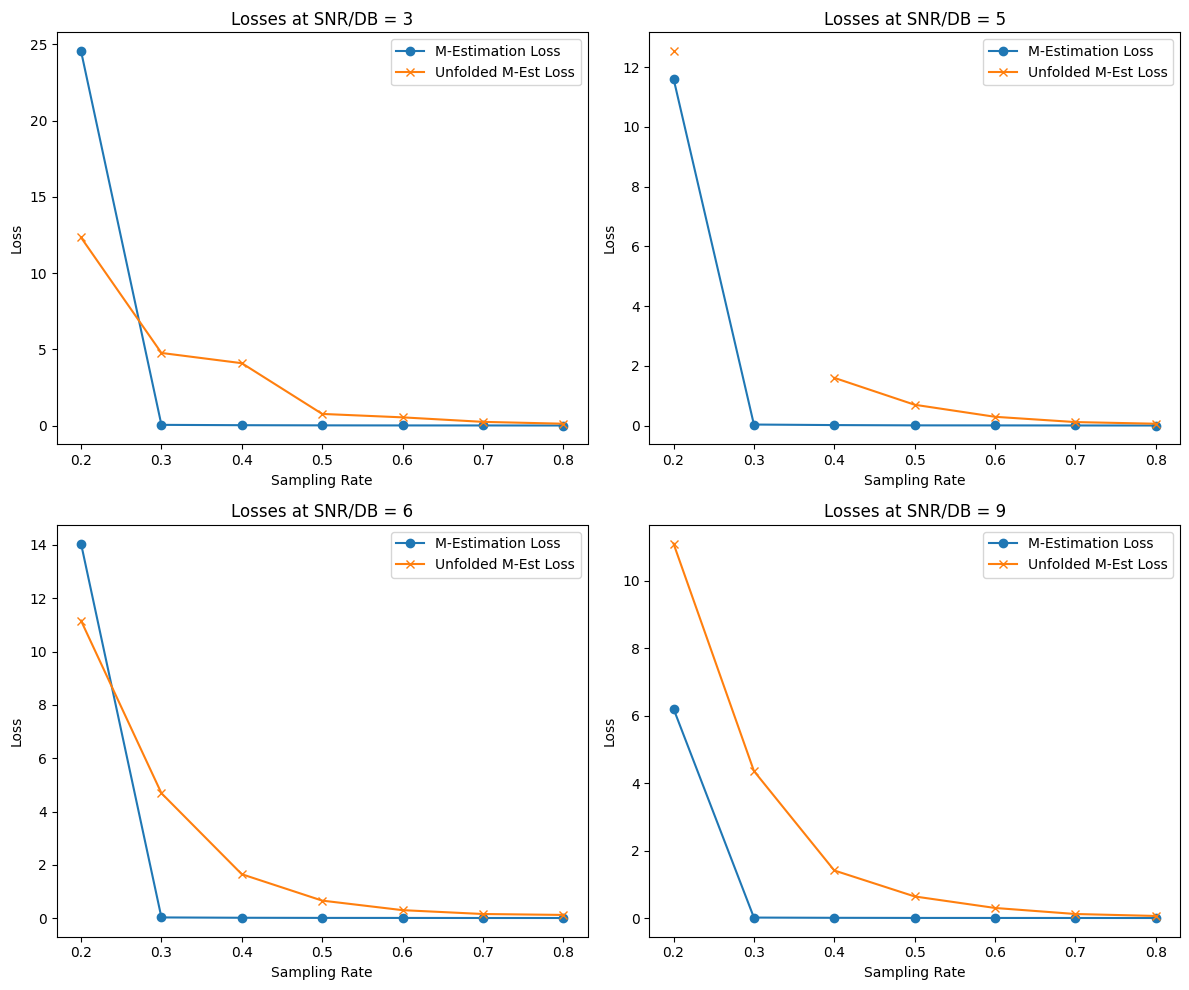

In [38]:
import matplotlib.pyplot as plt
# Sampling rates
sampling_rates = np.arange(0.2, 0.9, 0.1)

# SNR/DB levels
snr_db_levels = [3, 5, 6, 9]

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i in range(4):
    ax = axs[i // 2, i % 2]
    ax.plot(sampling_rates, array[i], marker='o', label='M-Estimation Loss')
    ax.plot(sampling_rates, unfolded_results[i], marker='x', label='Unfolded M-Est Loss')
    ax.set_title(f'Losses at SNR/DB = {snr_db_levels[i]}')
    ax.set_xlabel('Sampling Rate')
    ax.set_ylabel('Loss')
    ax.legend()

plt.tight_layout()
plt.show()



Testing Training Loop

In [4]:
# Get parameters --> for convhubermc: c, lambda, sigma, mu, delta, tau
def get_default_param(gpu = True):
    params_net = {}
    params_net['size1'] = 150
    params_net['size2'] = 300
    params_net['rank'] = 10
    
    params_net['device'] = device

    params_net['hubreg_iters'] = 2
    params_net['layers'] = 3
    params_net['kernel'] = (3, 3)
    
    params_net['CalInGPU'] = gpu
    
    return params_net

In [5]:
# seed = 123
# torch.manual_seed(seed)
# target = (torch.randn(30, 50))
# input_tensor = target * torch.bernoulli(torch.full((30, 50), 0.2))
# model = architecture.UnfoldedNet_Huber(params = get_default_param(False))

# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters())

# model.train()
# output = model(input_tensor)

# loss = (criterion(output, target))/torch.square(torch.norm(target, p = 'fro'))
# optimizer.zero_grad()
# print(f'loss before backward: {loss}, loss.grad: {loss.requires_grad}')
# loss.backward()
# print(f'loss: {loss}')
# print("\nGradients after one epoch:")
# for name, param in model.named_parameters():
#     print(f'name: {name}\t\tgradient: {param.grad}')
# optimizer.step()

In [6]:
# # Create a input_tensor of random indices
# shuffled_indices = torch.randperm(input_tensor.nelement())

# # Index the original input_tensor with these shuffled indices
# shuffled_input_tensor = input_tensor.view(-1)[shuffled_indices].view(input_tensor.size())

# output = model(shuffled_input_tensor)

# loss = (criterion(output, target))/torch.square(torch.norm(target, p = 'fro'))
# optimizer.zero_grad()
# print(f'loss before backward: {loss}, loss.grad: {loss.requires_grad}')
# loss.backward()
# print(f'loss: {loss}')
# print("\nGradients after one epoch:")
# for name, param in model.named_parameters():
#     print(f'name: {name}\t\tgradient: {param.grad}')
# optimizer.step()

In [7]:
# # Create a input_tensor of random indices
# shuffled_indices = torch.randperm(input_tensor.nelement())

# # Index the original input_tensor with these shuffled indices
# shuffled_input_tensor = input_tensor.view(-1)[shuffled_indices].view(input_tensor.size())

# output = model(shuffled_input_tensor)

# loss = (criterion(output, target))/torch.square(torch.norm(target, p = 'fro'))
# optimizer.zero_grad()
# print(f'loss before backward: {loss}, loss.grad: {loss.requires_grad}')
# loss.backward()
# print(f'loss: {loss}')
# print("\nGradients after one epoch:")
# for name, param in model.named_parameters():
#     print(f'name: {name}\t\tgradient: {param.grad}')
# optimizer.step()

In [8]:
model = revised_architecture.UnfoldedNet_Huber(params = get_default_param(False))
model

UnfoldedNet_Huber(
  (conv_layers): ModuleList(
    (0-449): 450 x Conv2dC(
      (convR): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (huber_obj): Sequential(
    (0): Huber(
      (conv_layers): ModuleList(
        (0-449): 450 x Conv2dC(
          (convR): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (1): Huber(
      (conv_layers): ModuleList(
        (0-449): 450 x Conv2dC(
          (convR): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (2): Huber(
      (conv_layers): ModuleList(
        (0-449): 450 x Conv2dC(
          (convR): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
  )
)

In [9]:
# model.forward(torch.randn(150, 300) * torch.bernoulli(torch.full((150, 300), 0.2)))
# model.forward(torch.randn(30, 50) * torch.bernoulli(torch.full((30, 50), 0.2)))


In [10]:
summary(model, input_size = [150, 300])

Layer (type:depth-idx)                   Output Shape              Param #
UnfoldedNet_Huber                        [150, 300]                --
├─Sequential: 1-1                        [150, 300]                --
│    └─Huber: 2-1                        [150, 300]                4,500
│    └─Huber: 2-4                        --                        (recursive)
│    │    └─ModuleList: 3-3              --                        (recursive)
│    └─Huber: 2-3                        [150, 300]                4,500
│    └─Huber: 2-4                        --                        (recursive)
│    │    └─ModuleList: 3-3              --                        (recursive)
│    └─Huber: 2-5                        [150, 300]                4,500
│    │    └─ModuleList: 3-3              --                        (recursive)
Total params: 17,990
Trainable params: 17,990
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 27
Input size (MB): 0.18
Forward/backward pass size (MB): 21.60
Pa

Project Name: Try 1 HuberMC-Net Q 20.0% DB 6.0

Configuring Network...
Instantiating Model...
Model Instantiated...

Parameters = 
{'size1': 150, 'size2': 300, 'rank': 10, 'device': 'cpu', 'hubreg_iters': 2, 'layers': 3, 'kernel': (3, 3), 'CalInGPU': False}

Epoch: 1, 2024-03-25 22:36:35, 

Epoch [1/20], Mean Training Loss:6.56797e-05, Mean Validation Loss:1.15343e+01
Epoch: 2, 2024-03-25 22:43:56, 

Epoch [2/20], Mean Training Loss:6.34607e-05, Mean Validation Loss:1.15506e+01
Epoch: 3, 2024-03-25 22:50:01, 

Epoch [3/20], Mean Training Loss:6.21627e-05, Mean Validation Loss:1.15263e+01
Epoch: 4, 2024-03-25 22:56:09, 

Epoch [4/20], Mean Training Loss:6.12525e-05, Mean Validation Loss:1.15282e+01
Epoch: 5, 2024-03-25 23:04:31, 

Epoch [5/20], Mean Training Loss:6.04875e-05, Mean Validation Loss:1.15217e+01
Saving Whole Model at Epochs: [5/20]
Saving Model Dict at Epochs: [5/20]
Epoch: 6, 2024-03-25 23:10:46, 

Epoch [6/20], Mean Training Loss:5.98158e-05, Mean Validation Loss:1.14956e

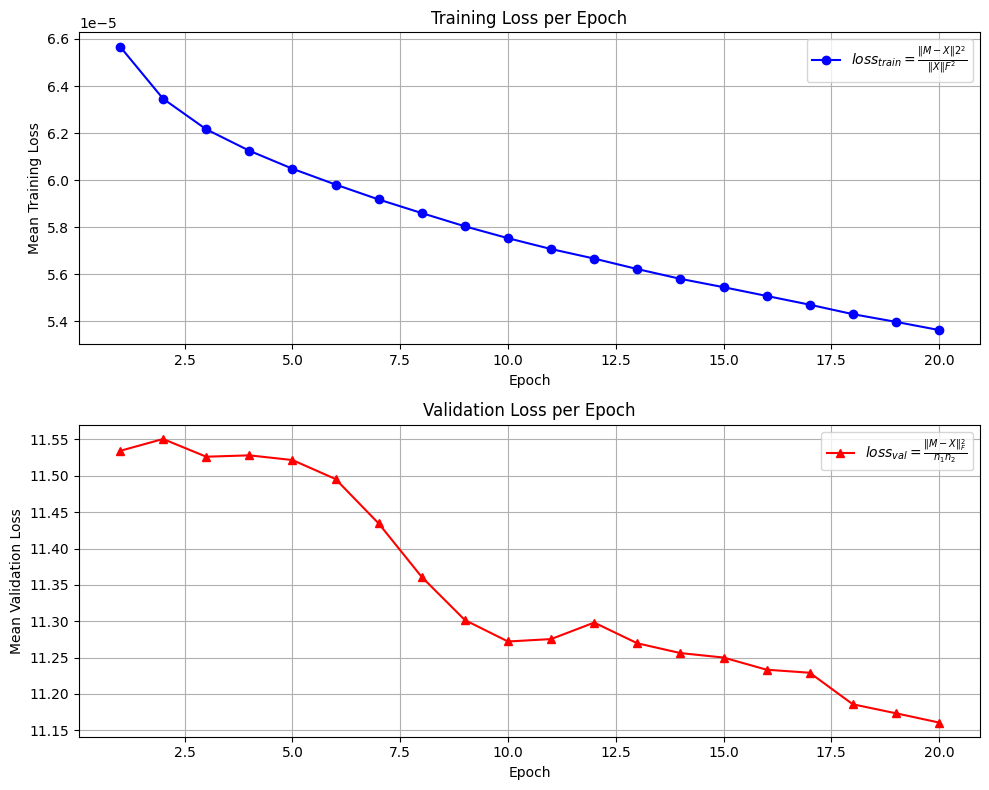

<Figure size 640x480 with 0 Axes>

In [11]:
# Some settings for visualisation
matplotlib.use('Agg')
%matplotlib inline

seed = 123
torch.manual_seed(seed)

# Set parameters (including hyperparameters) and setting for saving/logging data
hyper_param_net = training.get_hyperparameter_grid('HuberMC-Net', TrainInstances = 20, ValInstances = 10, BatchSize = 5, ValBatchSize = 2, num_epochs = 20, learning_rate = 0.001)
params_net = get_default_param(gpu = False)
CalInGPU = params_net['CalInGPU']

q_list = [0.2]
db_list = [6.0]

for q in q_list:
    for db in db_list:
        # ProjectName = TRY + ' ' + logs_and_results.get_current_time() + ' ' + hyper_param_net['Model'] + ' ' + 'Sampling Rate: ' + logs_and_results.get_q_str(q) + ' and DB ' + logs_and_results.get_noise_str(db)

        ProjectName = TRY + ' ' + hyper_param_net['Model'] + ' Q ' + logs_and_results.get_q_str(q) + ' DB ' + logs_and_results.get_noise_str(db)
        # Note: Removed time stamp from log file name as : not supported. Weird because this was not a problem in linux

        # Get log file
        logfile = logs_and_results.get_modularized_record(ProjectName, q, db, 'Logs', hyper_param_net, params_net, ROOT, SESSION)
        with open(logfile, 'w', 1) as log:
            print('Project Name: %s\n'%ProjectName)
            log.write('Project Name: %s\n\n'%ProjectName)

            # Get Model
            net = training.get_model(params_net, hyper_param_net, log)
            print('\nParameters = \n%s\n'%str(params_net))
            log.write('\nParameters = \n%s\n\n'%str(params_net))

            #Loading data and creating dataloader for both test and training
            # print('Loading Data phase...')
            log.write('Loading phase...\n')
            shape_dset = (params_net['size1'], params_net['size2'])
            
            train_loader, val_loader = dataset_processing.get_dataloaders(params_net = params_net, hyper_param_net = hyper_param_net, sampling_rate = q, db = db, ROOT = ROOT)

            # print('Finished loading.\n')
            log.write('Finished loading.\n\n')

            # Some additional settings for training including loss, optimizer,
            # floss = nn.functional.mse_loss(reduction = 'sum')
            floss = nn.MSELoss()
            optimizer = torch.optim.Adam(net.parameters(), lr = hyper_param_net['Lr'])
            # scheduler2 =  torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1, gamma = 0.97, verbose = True)

            # Array for recording parameter values after each layer for each epoch etc
            outputs_L = revised_architecture.to_var(torch.zeros([shape_dset[0], shape_dset[1]]), CalInGPU) 
            lossmean_vec = np.zeros((hyper_param_net['Epochs'], ))
            lossmean_val_vec = np.zeros((hyper_param_net['Epochs'], ))


            # dummy variable to monitor and record progress for loss
            minloss = np.inf

            for epoch in range(hyper_param_net['Epochs']):
                print(f'Epoch: {epoch + 1}, {logs_and_results.get_current_time()}, \n')
                log.write(f'Epoch: {epoch + 1} ')
                log.write(logs_and_results.get_current_time() + '\n\n')

                # Train and Test Steps. (Record every 5 epochs)
                if (epoch + 1) % 5 == 0:
                    # print('Loading and calculating training batches...')
                    log.write('Loading and calculating training batches...\n')
                    startime = time.time()
                    loss_mean = training.train_step(net, train_loader, floss, optimizer, CalInGPU, hyper_param_net['TrainInstances'], hyper_param_net['BatchSize']) # remove alpha from train func
                    endtime = time.time()
                    # print('Training time is %f'%(endtime - startime))
                    log.write('Training time is %f'%(endtime - startime))

                    # print('Loading and calculating validation batches...')
                    log.write('Loading and calculating validation batches...\n')
                    startime = time.time()
                    loss_val_mean = training.test_step(net, val_loader, floss, CalInGPU, hyper_param_net['ValInstances'], hyper_param_net['ValBatchSize'])
                    endtime = time.time()
                    # print('Test time is %f'%(endtime - startime))
                    log.write('Test time is %f'%(endtime - startime))

                else:
                    loss_mean = training.train_step(net, train_loader, floss, optimizer, CalInGPU, hyper_param_net['TrainInstances'], hyper_param_net['BatchSize'])
                    loss_val_mean = training.test_step(net, val_loader, floss, CalInGPU, hyper_param_net['ValInstances'], hyper_param_net['ValBatchSize'])

                # Update Record and Parameters
                lossmean_vec[epoch] = loss_mean
                lossmean_val_vec[epoch] = loss_val_mean


                print('Epoch [%d/%d], Mean Training Loss:%.5e, Mean Validation Loss:%.5e'
                      %(epoch + 1, hyper_param_net['Epochs'], loss_mean, loss_val_mean))

                # Update Log after every 5 epochs. Make a plot of MSE against epochs every 5 epochs. Save Model in whole/dict form every five epochs.
                if (epoch + 1) % 5 == 0:
                    print(f"Saving Whole Model at Epochs: [{epoch + 1}/{hyper_param_net['Epochs']}]")
                    model_whole_path = logs_and_results.get_modularized_record(ProjectName, q, db, 'Saved Models - Whole', hyper_param_net, params_net, ROOT, SESSION, current_epoch = epoch + 1)
                    # torch.save(net, model_whole_path)
                    print(f"Saving Model Dict at Epochs: [{epoch + 1}/{hyper_param_net['Epochs']}]")
                    model_state_dict_path = logs_and_results.get_modularized_record(ProjectName, q, db, 'Saved Models - Dict', hyper_param_net, params_net, ROOT, SESSION, current_epoch = epoch + 1)
                    # torch.save(net.state_dict(), model_state_dict_path)

                    # print('Epoch [%d/%d], Mean Training Loss:%.5e, Mean Validation Loss:%.5e'
                    # %(epoch + 1, hyper_param_net['Epochs'], loss_mean, loss_val_mean))
                    # print('loss_lowrank_mean', loss_lowrank_mean)
                    # print('loss_val_lowrank_mean', loss_val_lowrank_mean)
                    # print(f'c: {c_list}, lamda: {lamda_list}, mu: {mu_list}')

                    # log.write('loss_lowrank_mean %.5e\n' %(loss_lowrank_mean))
                    # log.write('loss_val_lowrank_mean %.5e\n' %(loss_val_lowrank_mean))
                    log.write('Epoch [%d/%d], Mean Training Loss:%.5e, Mean Validation Loss:%.5e\n'
                              %(epoch + 1, hyper_param_net['Epochs'], loss_mean, loss_val_mean))
                    np.set_printoptions(precision = 3)

                    if True or loss_val_mean < minloss:
                        # print('saved at [epoch%d/%d]'%(epoch + 1, hyper_param_net['Epochs']))
                        log.write('saved at [epoch%d/%d]\n' %(epoch + 1, hyper_param_net['Epochs']))
                        minloss = min(loss_val_mean, minloss)

            # Finish off by observing the minimum loss on validation set

            #Print min loss
            # print('\nMin Loss = %.4e'%np.min(lossmean_val_vec))
            log.write('\nMin Loss = %.4e'%np.min(lossmean_val_vec))

            # Plotting MSE vs Epoch and Saving it

            # Get Directory where we have to save the plot
            dir = logs_and_results.get_modularized_record(ProjectName, q, db, 'Plots', hyper_param_net, params_net, ROOT, SESSION, current_epoch = epoch + 1)
            logs_and_results.plot_and_save_mse_vs_epoch(lossmean_vec, lossmean_val_vec, dir)